# Large scale text analysis with deep learning

In this assignment, you will develop a deep learning model to predict salaries based on resumes (credits to to [Oleg Vasilev](https://github.com/Omrigan/)).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### About the challenge
For starters, let's download and unpack the data from [here].

You can also get it from [yadisk url](https://yadi.sk/d/vVEOWPFY3NruT7) the competition [page](https://www.kaggle.com/c/job-salary-prediction/data) (pick `Train_rev1.*`).

In [2]:
!wget -O Train_rev1.zip https://www.dropbox.com/scl/fi/9fy81b0tzuybb2wx48w14/Train_rev1.zip?rlkey=w3sqhym07l6nn89hwqb01pjmx&st=c10n9jqu&dl=1
data = pd.read_csv("./Train_rev1.zip", compression='zip', index_col=None)
data.shape

--2024-11-14 17:56:57--  https://www.dropbox.com/scl/fi/9fy81b0tzuybb2wx48w14/Train_rev1.zip?rlkey=w3sqhym07l6nn89hwqb01pjmx
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uc156d400b9702e608ffc274bfa0.dl.dropboxusercontent.com/cd/0/inline/CeZRkfTDPCUxKOcEbt6GXniGaE8dHMcxyMpSE1lNBFqWia73ty3onpEH4fV3VKW7Adltzlz8ArjWa6nd1QkhupwjSVUuKeNYxL3_vD9uA_6GTel3M1kPx6WtEWthgQndq1mVPMuULQtcUK9YtogX4Rea/file# [following]
--2024-11-14 17:56:59--  https://uc156d400b9702e608ffc274bfa0.dl.dropboxusercontent.com/cd/0/inline/CeZRkfTDPCUxKOcEbt6GXniGaE8dHMcxyMpSE1lNBFqWia73ty3onpEH4fV3VKW7Adltzlz8ArjWa6nd1QkhupwjSVUuKeNYxL3_vD9uA_6GTel3M1kPx6WtEWthgQndq1mVPMuULQtcUK9YtogX4Rea/file
Resolving uc156d400b9702e608ffc274bfa0.dl.dropboxusercontent.com (uc156d400b9702e608ffc274bfa0.dl.dropboxusercontent.com)... 162.125.1.15, 2620

(244768, 12)

In [3]:
data.head()

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName
0,12612628,Engineering Systems Analyst,Engineering Systems Analyst Dorking Surrey Sal...,"Dorking, Surrey, Surrey",Dorking,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk
1,12612830,Stress Engineer Glasgow,Stress Engineer Glasgow Salary **** to **** We...,"Glasgow, Scotland, Scotland",Glasgow,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 35000/annum 25-35K,30000,cv-library.co.uk
2,12612844,Modelling and simulation analyst,Mathematical Modeller / Simulation Analyst / O...,"Hampshire, South East, South East",Hampshire,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 40000/annum 20-40K,30000,cv-library.co.uk
3,12613049,Engineering Systems Analyst / Mathematical Mod...,Engineering Systems Analyst / Mathematical Mod...,"Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 30000/annum 25K-30K negotiable,27500,cv-library.co.uk
4,12613647,"Pioneer, Miser Engineering Systems Analyst","Pioneer, Miser Engineering Systems Analyst Do...","Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk


One problem with salary prediction is that it's oddly distributed: there are many people who are paid standard salaries and a few that get tons o money. The distribution is fat-tailed on the right side, which is inconvenient for MSE minimization.

There are several techniques to combat this: using a different loss function, predicting log-target instead of raw target or even replacing targets with their percentiles among all salaries in the training set. We gonna use logarithm for now.

_You can read more [in the official description](https://www.kaggle.com/c/job-salary-prediction#description)._

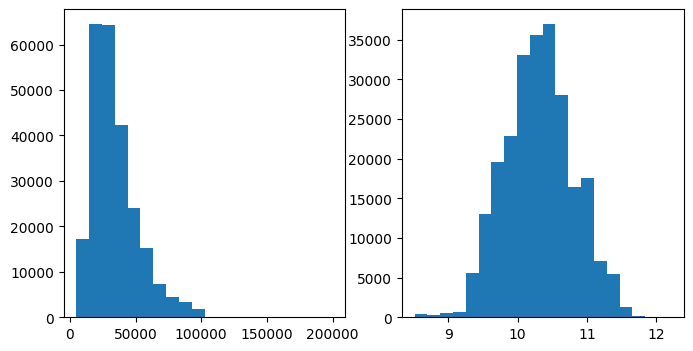

In [ ]:
data['Log1pSalary'] = np.log1p(data['SalaryNormalized']).astype('float32')

plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.hist(data["SalaryNormalized"], bins=20);

plt.subplot(1, 2, 2)
plt.hist(data['Log1pSalary'], bins=20);

Our task is to predict one number, __Log1pSalary__.

To do so, our model can access a number of features:
* Free text: __`Title`__ and  __`FullDescription`__
* Categorical: __`Category`__, __`Company`__, __`LocationNormalized`__, __`ContractType`__, and __`ContractTime`__.

In [ ]:
text_columns = ["Title", "FullDescription"]
categorical_columns = ["Category", "Company", "LocationNormalized", "ContractType", "ContractTime"]
TARGET_COLUMN = "Log1pSalary"

data[categorical_columns] = data[categorical_columns].fillna('NaN') # cast missing values to string "NaN"

data.sample(3)

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName,Log1pSalary
55224,68679044,Client Development Manager,As one of the UK's top 10 software vendors my ...,Birmingham West Midlands (County) West Midlands,UK,NaN,permanent,Genesis Associates,Sales Jobs,30000 - 40000 per annum + Double OTE + Benefits,35000,totaljobs.com,10.463132
158677,71148327,Buyer (Co Antrim) ****K,Our Client has for many years been an Ulster a...,"Northern Ireland, Co. Antrim, Lisburn",UK,full_time,permanent,Cranmore Recruitment,Retail Jobs,"20,000 - 30,000",25000,nijobfinder.co.uk,10.126671
167871,71308890,Depot Manager,Depot Manager A Depot Manager is now being rec...,Preston,Preston,full_time,NaN,Path Recruitment,Consultancy Jobs,"Circa 38,000 plus company car plus bonus plus ...",38000,Jobcentre Plus,10.545368


### Preprocessing text data

Just like last week, applying NLP to a problem begins from tokenization: splitting raw text into sequences of tokens (words, punctuation, etc).

__Your task__ is to lowercase and tokenize all texts under `Title` and `FullDescription` columns. Store the tokenized data as a __space-separated__ string of tokens for performance reasons.

It's okay to use nltk tokenizers. Assertions were designed for WordPunctTokenizer, slight deviations are okay.

In [ ]:
print("Raw text:")
print(data["FullDescription"][2::100000])

Raw text:
2         Mathematical Modeller / Simulation Analyst / O...
100002    A successful and high achieving specialist sch...
200002    Web Designer  HTML, CSS, JavaScript, Photoshop...
Name: FullDescription, dtype: object


In [ ]:
def tokenize_row(row: str) -> str:
    row = str(row)
    return ' '.join(tokenizer.tokenize(row)).lower()

In [ ]:
import nltk

tokenizer = nltk.tokenize.WordPunctTokenizer()
for col in text_columns:
    data[col] = data[col].apply(tokenize_row)


Now we can assume that our text is a space-separated list of tokens:

In [ ]:
print("Tokenized:")
print(data["FullDescription"][2::100000])
assert data["FullDescription"][2][:50] == 'mathematical modeller / simulation analyst / opera'
assert data["Title"][54321] == 'international digital account manager ( german )'

Tokenized:
2         mathematical modeller / simulation analyst / o...
100002    a successful and high achieving specialist sch...
200002    web designer html , css , javascript , photosh...
Name: FullDescription, dtype: object


Not all words are equally useful. Some of them are typos or rare words that are only present a few times.

Let's count how many times is each word present in the data so that we can build a "white list" of known words.

In [ ]:
from collections import Counter
token_counts = Counter()

In [ ]:
token_counts += Counter(data['Title'].values[1].split())

In [ ]:
from collections import Counter
token_counts = Counter()

# Count how many times does each token occur in both "Title" and "FullDescription" in total
for title in data['Title'].values:
    for token in title.split():
        token_counts[token] += 1
for desc in data['FullDescription'].values:
    for token in desc.split():
        token_counts[token] += 1

In [ ]:
print("Total unique tokens :", len(token_counts))
print('\n'.join(map(str, token_counts.most_common(n=5))))
print('...')
print('\n'.join(map(str, token_counts.most_common()[-3:])))

assert token_counts.most_common(1)[0][1] in  range(2600000, 2700000)
assert len(token_counts) in range(200000, 210000)
print('Correct!')

Total unique tokens : 202704
('and', 2657388)
('.', 2523216)
(',', 2318606)
('the', 2080994)
('to', 2019884)
...
('stephanietraveltraderecruitmnt', 1)
('ruabon', 1)
('lowehays', 1)
Correct!


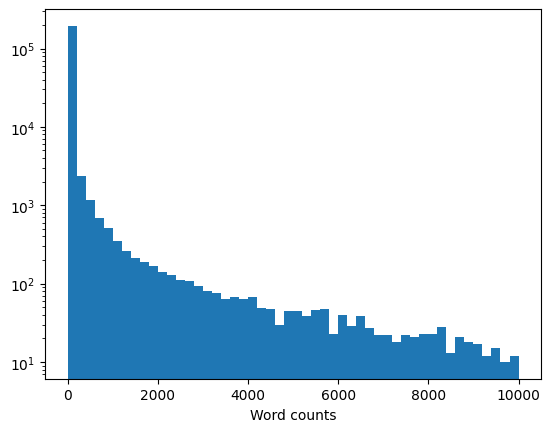

In [ ]:
# Let's see how many words are there for each count
plt.hist(list(token_counts.values()), range=[0, 10**4], bins=50, log=True)
plt.xlabel("Word counts");

__Task 1.1__ Get a list of all tokens that occur at least 10 times.

In [ ]:
min_count = 10

# tokens from token_counts keys that had at least min_count occurrences throughout the dataset
tokens = sorted(t for t, c in token_counts.items() if c >= min_count)

# Add a special tokens for unknown and empty words
UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + tokens

In [ ]:
print("Vocabulary size:", len(tokens))
assert type(tokens) == list
assert len(tokens) in range(32000, 35000)
assert 'me' in tokens
assert UNK in tokens
print("Correct!")

Vocabulary size: 34158
Correct!


__Task 1.2__ Build an inverse token index: a dictionary from token(string) to it's index in `tokens` (int)

In [ ]:
tokens.index('PAD')

1

In [ ]:
token_to_id ={token: ind for ind, token in enumerate(tokens)}

In [ ]:
assert isinstance(token_to_id, dict)
assert len(token_to_id) == len(tokens)
for tok in tokens:
    assert tokens[token_to_id[tok]] == tok

print("Correct!")

Correct!


And finally, let's use the vocabulary you've built to map text lines into neural network-digestible matrices.

In [ ]:
sequences = data['Title']

In [ ]:
sequences[sequences.apply(len) == 202]

,Title
26468,"oracle apps financials developer ( sql , pl / ..."


In [ ]:
UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))

    max_len = min(max(map(len, sequences)), max_len or float('inf'))

    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    for i,seq in enumerate(sequences):
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix

    return matrix

In [ ]:
print("Lines:")
print('\n'.join(data["Title"][::100000].values), end='\n\n')
print("Matrix:")
print(as_matrix(data["Title"][::100000]))

Lines:
engineering systems analyst
hr assistant
senior ec & i engineer

Matrix:
[[10807 30161  2166     1     1]
 [15020  2844     1     1     1]
 [27645 10201    16 15215 10804]]


Now let's  encode the categirical data we have.

As usual, we shall use one-hot encoding for simplicity. Kudos if you implement more advanced encodings: tf-idf, pseudo-time-series, etc.

In [ ]:
data[categorical_columns].apply(dict, axis=1)

,0
0,"{'Category': 'Engineering Jobs', 'Company': 'G..."
1,"{'Category': 'Engineering Jobs', 'Company': 'G..."
2,"{'Category': 'Engineering Jobs', 'Company': 'G..."
3,"{'Category': 'Engineering Jobs', 'Company': 'G..."
4,"{'Category': 'Engineering Jobs', 'Company': 'G..."
...,...
244763,"{'Category': 'Teaching Jobs', 'Company': 'NaN'..."
244764,"{'Category': 'Teaching Jobs', 'Company': 'NaN'..."
244765,"{'Category': 'Teaching Jobs', 'Company': 'NaN'..."
244766,"{'Category': 'Teaching Jobs', 'Company': 'NaN'..."


In [ ]:
from sklearn.feature_extraction import DictVectorizer

# we only consider top-1k most frequent companies to minimize memory usage
top_companies, top_counts = zip(*Counter(data['Company']).most_common(1000))
recognized_companies = set(top_companies)
data["Company"] = data["Company"].apply(lambda comp: comp if comp in recognized_companies else "Other")

categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
categorical_vectorizer.fit(data[categorical_columns].apply(dict, axis=1))

DictVectorizer(dtype=<class 'numpy.float32'>, sparse=False)

### The deep learning part

Once we've learned to tokenize the data, let's design a machine learning experiment.

As before, we won't focus too much on validation, opting for a simple train-test split.

__To be completely rigorous,__ we've comitted a small crime here: we used the whole data for tokenization and vocabulary building. A more strict way would be to do that part on training set only. You may want to do that and measure the magnitude of changes.

In [ ]:
from sklearn.model_selection import train_test_split

data_train, data_val = train_test_split(data, test_size=0.2, random_state=42)
data_train.index = range(len(data_train))
data_val.index = range(len(data_val))

print("Train size = ", len(data_train))
print("Validation size = ", len(data_val))

Train size =  195814
Validation size =  48954


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


device = 'cuda' if torch.cuda.is_available() else 'cpu'


def to_tensors(batch, device):
    batch_tensors = dict()
    for key, arr in batch.items():
        if key in ["FullDescription", "Title"]:
            batch_tensors[key] = torch.tensor(arr, device=device, dtype=torch.int64)
        else:
            batch_tensors[key] = torch.tensor(arr, device=device)
    return batch_tensors


def make_batch(data, max_len=None, word_dropout=0, device=device):
    """
    Creates a keras-friendly dict from the batch data.
    :param word_dropout: replaces token index with UNK_IX with this probability
    :returns: a dict with {'title' : int64[batch, title_max_len]
    """
    batch = {}
    batch["Title"] = as_matrix(data["Title"].values, max_len)
    batch["FullDescription"] = as_matrix(data["FullDescription"].values, max_len)
    batch['Categorical'] = categorical_vectorizer.transform(data[categorical_columns].apply(dict, axis=1))

    if word_dropout != 0:
        batch["FullDescription"] = apply_word_dropout(batch["FullDescription"], 1. - word_dropout)

    if TARGET_COLUMN in data.columns:
        batch[TARGET_COLUMN] = data[TARGET_COLUMN].values

    return to_tensors(batch, device)

def apply_word_dropout(matrix, keep_prop, replace_with=UNK_IX, pad_ix=PAD_IX,):
    dropout_mask = np.random.choice(2, np.shape(matrix), p=[keep_prop, 1 - keep_prop])
    dropout_mask &= matrix != pad_ix
    return np.choose(dropout_mask, [matrix, np.full_like(matrix, replace_with)])

In [ ]:
[tokens[idx] for idx in [27645, 29893, 33674,     1,     1,     1,     1]]

['senior', 'support', 'worker', 'PAD', 'PAD', 'PAD', 'PAD']

#### Architecture

Our basic model consists of three branches:
* Title encoder
* Description encoder
* Categorical features encoder

We will then feed all 3 branches into one common network that predicts salary.

![scheme](https://github.com/yandexdataschool/nlp_course/raw/master/resources/w2_conv_arch.png)

In [ ]:
class TextEncoder(nn.Module):
    def __init__(self, embeddings, hid_size, window, dropout_prob=0.2, pooling='mot'):
        super().__init__()
        self.emb = embeddings
        self.emb_size = self.emb.weight.shape[1]
        self.pooling_type = pooling

        # convolution layers
        self.conv1 = nn.Conv1d(self.emb_size, hid_size, window)
        self.conv2 = nn.Conv1d(self.emb_size, hid_size, window)
        self.bn1 = nn.BatchNorm1d(hid_size)
        self.bn2 = nn.BatchNorm1d(hid_size)
        self.dropout = nn.Dropout(p=dropout_prob)

        # cast concatenated conv layers back to the hidden size
        self.fc = nn.Linear(in_features=2*hid_size, out_features=hid_size)


    def forward(self, text_indices):
        embs = self.emb(text_indices).transpose(2, 1)
        conv_outs1 = self.dropout(self.bn1(self.conv1(embs)))
        conv_outs2 = self.dropout(self.bn2(self.conv2(embs)))
        conv_outs = torch.cat((conv_outs1, conv_outs2), dim=1)

        if self.pooling_type == 'mot':
            conv_max_pool = torch.max(conv_outs, axis=-1).values
        elif self.pooling_type == 'softmax':
            conv_outs_softmax = F.softmax(conv_outs, dim=1) * conv_outs
            conv_max_pool = torch.max(conv_outs_softmax, axis=-1).values
        else:
            raise ValueError(f"Unknown pooling type: {self.pooling_type}")

        return self.fc(conv_max_pool)

In [ ]:
# class SalaryPredictor(nn.Module):
#     def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=64):
#         super().__init__()
#         self.emb_size = 32
#         self.window = 3
#         self.hid_size = hid_size
#         self.emb = torch.nn.Embedding(n_tokens, self.emb_size)
#         self.title_encoder = TextEncoder(self.emb, self.hid_size, self.window)
#         self.descr_encoder = TextEncoder(self.emb, self.hid_size, self.window)
#         self.fc1 = nn.Linear(n_cat_features, self.hid_size)
#         self.fc2 = nn.Linear(self.hid_size * 3, 1)


#     def forward(self, batch):
#         title_emb_out = F.relu(self.title_encoder(batch['Title']))
#         descr_emb_out = F.relu(self.title_encoder(batch['FullDescription']))
#         categorical_emb_out = F.relu(self.fc1(batch['Categorical']))
#         concat_emb_out = torch.cat((title_emb_out, descr_emb_out, categorical_emb_out), dim=-1)
#         return self.fc2(concat_emb_out).squeeze()


In [ ]:
import gensim.downloader as api
gensim_model = api.load('glove-twitter-100')

[==================================================] 100.0% 387.1/387.1MB downloaded


In [ ]:
def torch_emb_from_gensim(gensim_model, tokens):
    n_tokens = len(tokens)
    embedding_dim = gensim_model.vector_size

    embedding_matrix = np.zeros((n_tokens, embedding_dim))

    for i, token in enumerate(tokens):
        if token in gensim_model:
            embedding_matrix[i] = gensim_model[token]
        else:
            embedding_matrix[i] = np.random.normal(scale=0.6, size=(embedding_dim,))

    return torch.tensor(embedding_matrix, dtype=torch.float, device=device)

In [ ]:
class SalaryPredictorGensim(nn.Module):
    def __init__(self, embeddings, n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=64, dropout_prob=0.2):
        super().__init__()
        self.window = 3
        self.hid_size = hid_size

        # create embedding table from pretrained weights in a tensor
        self.emb = nn.Embedding.from_pretrained(embeddings, freeze=False)

        # text encoder
        self.title_encoder = TextEncoder(self.emb, self.hid_size, self.window, pooling='softmax')
        self.descr_encoder = TextEncoder(self.emb, self.hid_size, self.window, pooling='softmax')
        self.bn_title = nn.BatchNorm1d(self.hid_size)
        self.bn_descr = nn.BatchNorm1d(self.hid_size)
        self.dropout_text = nn.Dropout(p=dropout_prob)

        # linear layers
        self.fc1 = nn.Linear(n_cat_features, self.hid_size)
        self.bn1 = nn.BatchNorm1d(self.hid_size)  # Batch Normalization for categorical features
        self.dropout = nn.Dropout(p=dropout_prob)


        self.fc2 = nn.Linear(self.hid_size * 3, 1)


    def forward(self, batch):
        # forward pass through the text encoders
        title_emb_out = F.relu(self.title_encoder(batch['Title']))
        descr_emb_out = F.relu(self.title_encoder(batch['FullDescription']))

        # batch norm to text encoders
        title_emb_out = self.bn_title(title_emb_out)
        descr_emb_out = self.bn_descr(descr_emb_out)

        # dropout to text encoders
        title_emb_out = self.dropout_text(title_emb_out)
        descr_emb_out = self.dropout_text(descr_emb_out)

        # categorical
        categorical_emb_out = F.relu(self.fc1(batch['Categorical']))
        categorical_emb_out = self.bn1(categorical_emb_out)
        categorical_emb_out = self.dropout(categorical_emb_out)

        concat_emb_out = torch.cat((title_emb_out, descr_emb_out, categorical_emb_out), dim=-1)
        return self.fc2(concat_emb_out).squeeze()

In [ ]:
embs_gensim = torch_emb_from_gensim(gensim_model, tokens)
model = SalaryPredictorGensim(embs_gensim).to(device)
batch = make_batch(data_train[:100], device=device)
criterion = nn.MSELoss()

dummy_pred = model(batch)
dummy_loss = criterion(dummy_pred, batch[TARGET_COLUMN])
assert dummy_pred.shape == torch.Size([100])
assert len(torch.unique(dummy_pred)) > 20, "model returns suspiciously few unique outputs. Check your initialization"
assert dummy_loss.ndim == 0 and 0. <= dummy_loss <= 250., "make sure you minimize MSE"

#### Training and evaluation

As usual, we gonna feed our monster with random minibatches of data.

As we train, we want to monitor not only loss function, which is computed in log-space, but also the actual error measured in dollars.

In [ ]:
def iterate_minibatches(data, batch_size=256, shuffle=True, cycle=False, device=device, **kwargs):
    """ iterates minibatches of data in random order """
    while True:
        indices = np.arange(len(data))
        if shuffle:
            indices = np.random.permutation(indices)

        for start in range(0, len(indices), batch_size):
            batch = make_batch(data.iloc[indices[start : start + batch_size]], device=device, **kwargs)
            yield batch

        if not cycle: break

### Model training

We can now fit our model the usual minibatch way. The interesting part is that we train on an infinite stream of minibatches, produced by `iterate_minibatches` function.

In [ ]:
from tqdm.auto import tqdm

BATCH_SIZE = 16
EPOCHS = 10

In [ ]:
def print_metrics(model, data, batch_size=BATCH_SIZE, name="", device=torch.device('cpu'), **kw):
    squared_error = abs_error = num_samples = 0.0
    model.eval()
    with torch.no_grad():
        for batch in iterate_minibatches(data, batch_size=batch_size, shuffle=False, device=device, **kw):
            batch_pred = model(batch)
            squared_error += torch.sum(torch.square(batch_pred - batch[TARGET_COLUMN]))
            abs_error += torch.sum(torch.abs(batch_pred - batch[TARGET_COLUMN]))
            num_samples += len(batch_pred)
    mse = squared_error.detach().cpu().numpy() / num_samples
    mae = abs_error.detach().cpu().numpy() / num_samples
    print("%s results:" % (name or ""))
    print("Mean square error: %.5f" % mse)
    print("Mean absolute error: %.5f" % mae)
    return mse, mae


In [ ]:
embs_gensim = torch_emb_from_gensim(gensim_model, tokens)
model = SalaryPredictorGensim(embs_gensim).to(device)
criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4)

for epoch in range(EPOCHS):
    print(f"epoch: {epoch}")
    model.train()
    for i, batch in tqdm(enumerate(
            iterate_minibatches(data_train, batch_size=BATCH_SIZE, device=device)),
            total=len(data_train) // BATCH_SIZE
        ):
        pred = model(batch)
        loss = criterion(pred, batch[TARGET_COLUMN])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print_metrics(model, data_val, device=device)



epoch: 0


  0%|          | 0/12238 [00:00<?, ?it/s]

 results:
Mean square error: 0.15096
Mean absolute error: 0.29666
epoch: 1


  0%|          | 0/12238 [00:00<?, ?it/s]

 results:
Mean square error: 0.12990
Mean absolute error: 0.27805
epoch: 2


  0%|          | 0/12238 [00:00<?, ?it/s]

### Bonus part: explaining model predictions

It's usually a good idea to understand how your model works before you let it make actual decisions. It's simple for linear models: just see which words learned positive or negative weights. However, its much harder for neural networks that learn complex nonlinear dependencies.

There are, however, some ways to look inside the black box:
* Seeing how model responds to input perturbations
* Finding inputs that maximize/minimize activation of some chosen neurons (_read more [on distill.pub](https://distill.pub/2018/building-blocks/)_)
* Building local linear approximations to your neural network: [article](https://arxiv.org/abs/1602.04938), [eli5 library](https://github.com/TeamHG-Memex/eli5/tree/master/eli5/formatters)

Today we gonna try the first method just because it's the simplest one.

In [ ]:
def explain(model, sample, col_name='Title'):
    """ Computes the effect each word had on model predictions """
    sample = dict(sample)
    sample_col_tokens = [tokens[token_to_id.get(tok, 0)] for tok in sample[col_name].split()]
    data_drop_one_token = pd.DataFrame([sample] * (len(sample_col_tokens) + 1))

    for drop_i in range(len(sample_col_tokens)):
        data_drop_one_token.loc[drop_i, col_name] = ' '.join(UNK if i == drop_i else tok
                                                   for i, tok in enumerate(sample_col_tokens))

    *predictions_drop_one_token, baseline_pred = model(make_batch(data_drop_one_token, device=device)).detach().cpu()
    diffs = baseline_pred - torch.Tensor(predictions_drop_one_token)
    return list(zip(sample_col_tokens, diffs))

In [ ]:
from IPython.display import HTML, display_html


def draw_html(tokens_and_weights, cmap=plt.get_cmap("bwr"), display=True,
              token_template="""<span style="background-color: {color_hex}">{token}</span>""",
              font_style="font-size:14px;"
             ):

    def get_color_hex(weight):
        rgba = cmap(1. / (1 + np.exp(float(weight))), bytes=True)
        return '#%02X%02X%02X' % rgba[:3]

    tokens_html = [
        token_template.format(token=token, color_hex=get_color_hex(weight))
        for token, weight in tokens_and_weights
    ]


    raw_html = """<p style="{}">{}</p>""".format(font_style, ' '.join(tokens_html))
    if display:
        display_html(HTML(raw_html))

    return raw_html


In [ ]:
i = 36605
tokens_and_weights = explain(model, data.loc[i], "Title")
draw_html([(tok, weight * 5) for tok, weight in tokens_and_weights], font_style='font-size:20px;');

tokens_and_weights = explain(model, data.loc[i], "FullDescription")
draw_html([(tok, weight * 10) for tok, weight in tokens_and_weights]);

sales specialist iv access and infusion

sales representative medical sales iv access and infusion an opportunity to work for the industry leading manufacturer of iv access and infusion solutions . formally recognised as the number **** company in this market space , our client are an ethical and dynamic organisation absolutely committed to the advancement of innovative technologies . job title : sales specialist iv access and infusion selling : medication delivery solutions selling to : iv teams , infection control , lead intensive care nurse specialists , ward managers territory : east midlands location : east midlands package : basic : **** k **** k , uncapped bonus in addition , full corporate benefits company information hugely ethical and professional global organisation extremely well established in the uk the market leader across all of their core business areas focus on providing cutting edge solutions along with outstanding service and support a business that retain talented personnel by offering a strong platform for career development sales specialist iv access and infusion you must have / be the following at least 2 years medical device sales experience . candidates who have sold disposables / consumables or similar into hospitals would be of particular interest . candidates must have sold into hospitals demonstrable performance and achievements so far personable , adaptable and willing to learn keen and eager to be a success candidates must have a degree or at least be able to show a strong ability to learn role information managing the east midlands region selling across the company ' s range of iv and infusion solutions portfolio selling into lead intensive care nurse specialists , ward managers , iv teams , infection control teams , procurement sales specialist iv access and infusion candidates must be eligible to work and live in the uk . please contact allan waller on **** **** **** or please hit the apply button . this job was originally posted as www . salestarget . co . uk / jobseeking / UNK ****

In [ ]:
i = 1207
tokens_and_weights = explain(model, data.loc[i], "Title")
draw_html([(tok, weight * 5) for tok, weight in tokens_and_weights], font_style='font-size:20px;');

tokens_and_weights = explain(model, data.loc[i], "FullDescription")
draw_html([(tok, weight * 10) for tok, weight in tokens_and_weights]);

rgn deputy manager northumberland

rgn qualified deputy manager northumberland **** per hour in touch recruitment are working on behalf of wellregarded nursing home group to recruit an experienced rgn deputy home manager for their medium sized nursing service in the stocksfield area of northumberland . the role will involve working alongside an experienced home manager to run and manage the service successfully . as deputy manager you will take an active clinical lead , overseeing care being delivered within the service whilst maintaining high standards at all times . working alongside the home manager you will supervise a multidisciplinary team and deal with all aspects of staff recruitment , disciplinary and appraisals and also play a key part in training and developing staff . the successful candidate will hold a 1st level nurse rgn qualification and active nmc pin . the role requires a strong nurse who has experience working within a nursing home environment within a supervisory role . to apply please send your cv across to danielle at danielleintouchrecruitment . co . uk or alternatively call **** **** **** for an application form keywords sister , deputy home manager , deputy nursing home manager , , head of care , nurse , nursing home , rgn , senior nurse , sister , elderly care , deputy home manager , clinical lead , newcastle , northumberland , stocksfield , tyne and wear , north east

In [ ]:
i = np.random.randint(len(data))
print("Index:", i)
print("Salary (gbp):", np.expm1(model(make_batch(data.iloc[i: i+1], device=device)).detach().cpu()))

tokens_and_weights = explain(model, data.loc[i], "Title")
draw_html([(tok, weight * 5) for tok, weight in tokens_and_weights], font_style='font-size:20px;');

tokens_and_weights = explain(model, data.loc[i], "FullDescription")
draw_html([(tok, weight * 10) for tok, weight in tokens_and_weights]);

__Terrible start-up idea #1962:__ make a tool that automaticaly rephrases your job description (or CV) to meet salary expectations :)